# `sparsetorch`-Package Tutorial
## Installation
Information about installation is given inside the package folder.
All relevant information are given in the `readme.txt` file.
## About this Tutorial
This tutorial provides a guide on how to use the package. We will show all the steps to approximate a 2D function. The approach can easily be generalized for higher dimensional functions.

Before we get started, we define the function we want to approximate:

In [34]:
import torch

# example function defined on interval [0,1]
def f_dD(x):
    result = 4 * x[0] * (x[0] - 1)
    for x_i in x[1:]:
        result *= 4 * x_i * (x_i - 1)
    result *= torch.exp(2 * torch.prod(x, dim=0))
    return result

## 1. Choosing Appropriate 1D basis functions
A wide range of 1D basis functions is defined in the package. They are split into two classes, which require a slightly different approach during initialization. The first type of basis functions is defined on a grid. The package provides either the `Hat` or the `Gauss` basis.

In [35]:
from sparsetorch.oneD_basis_functions import Hat, Gauss

# choose basis function type: Hat or Gauss
basis_x = Hat
# define highest level of basis function in 1D
level_x = 5
# generate basis functions on interval [0,1]
# without basis functions on boundary
bf_1D_x = basis_x.hierarchical(level_x, boundary=False, a=0, b=1)
# print number of basis functions
print("Number of basis functions: ", bf_1D_x.bf_num)

Number of basis functions:  63


The second type of basis functions are the orthogonal basis functions, e.g. `Fourier`, `Chebyshev` or `Legendre`.

In [36]:
from sparsetorch.oneD_basis_functions import Fourier, Chebyshev, Legendre

# choose basis function type: Fourier, Chebyshev, Legendre
basis_y = Fourier
# define highest level of basis function in 1D
level_y = 50
# generate basis functions on interval [0,1]
bf_1D_y = basis_y(level_y, a=0, b=1)
# print number of basis functions
print("Number of basis functions: ", bf_1D_y.bf_num)

Number of basis functions:  101


## 2. From 1D to dD
To go from 1D to dD we need to combine the basis functions defined in 1D. One can choose between three types of combination methods: `Tensorprod`, `Elemprod` or `Sparse`. `Tensorprod` considers all possible basis functions, `Elemprod` requires each higher dimensional basis function to be defined individualy and `Sparse` combination applies a sparse grid approach for basis function combination. Note that `Elemprod` requires the same number of 1D basis functions in each dimension. (`Elemprod` will not be demonstrated here.)

In [37]:
from sparsetorch.dD_basis_functions import Tensorprod, Elemprod, Sparse

# dimension of function
n_dim = 2

# choose combination method: Tensorprod, Elemprod (or Sparse)
BF_dD = Sparse
# group all 1D basis functions inside list
all_bfs_1D = [bf_1D_x, bf_1D_y]
# alternatively: same basis functions in all dimensions (especially for `n_dim >> 2`):
#all_bfs_1D = [bf_1D_x] * n_dim
# create higher dimensional basis
bf_dD = BF_dD(all_bfs_1D)

## 3. Get Approximation
Computing the approximation requires creating the model first. Technically speaking, this is the where we add weights to the basis functions generated so far.

In [38]:
from sparsetorch.solver import Model

# create model
model = Model(bf_dD, bf_dD.bf_num)

Running an optimizer requires training data. The package provides utilities to generate coordinates for training evaluations. Methods for random point generation or generation on a regular grid are currently provided.

In [39]:
from sparsetorch.utils import get_equidist_coord, get_rand_coord

# define number of evaluations in each dimension
eval_num = 120
# generate coordinates for training evaluations
# alternatively use: get_rand_coord
input = get_equidist_coord(torch.zeros(n_dim), torch.ones(n_dim),
                               torch.ones(n_dim) * eval_num)
# get function evaluations
target = f_dD(input)

The input and target data can now be fed to a solver. Two possible solver calls are provided in the implementation: a least squares solver and a more general solver, that can be configured with gradient based solvers provided by the `torch` package. Both possibilities are shown in the following. We start with the least squares solver. Note that the solver overwrites the model weights when called. Therefore a new model is defined for the second optimizer.

In [40]:
from sparsetorch.solver import Solver

# create solver
solver = Solver(model, input, target)

### a) Least Squares Solver

In [41]:
# call solver procedure (could take some time depending on hardware)
solver.le()

### b) SGD Optimizer

In [42]:
# define new model and new solver
model2 = Model(bf_dD, bf_dD.bf_num)
solver2 = Solver(model2, input, target)

# optimizer settings
criterion = torch.nn.MSELoss()  # loss function
lr = 0.3  # learning rate
momentum = 0.9  # momentum factor
eps = 10e-4  # threshold for loss
max_it = 100 # maximum number of iterations

# choose torch optimizer
optimizer = torch.optim.SGD(model2.parameters(), lr=lr, 
                            momentum=momentum)

# call solver procedure (could take some time depending on hardware)
solver2.general(criterion, optimizer, eps, max_it=max_it)

Current iteration: 10
Current loss: 2.5019e-01
Current iteration: 20
Current loss: 7.9230e-02
Current iteration: 30
Current loss: 2.7013e-02
Current iteration: 40
Current loss: 5.2963e-03
Final loss: 9.4437e-04


## 4. Compute Derivative of Approximation
The benefit of having created the function model in `torch`, is that automatic gradient computation is provided. We can also explicitely compute the derivative of our function approximation. This is explained in the following.

In [43]:
# assume we want derivatives of model in points on equidisttant grid

# define steps in each dimension, i.e. number of points in each dimension
# (higher number might take long time and use a lot of memory)
steps = 20

# generate points
points = get_equidist_coord(torch.zeros(n_dim), torch.ones(n_dim), steps*torch.ones(n_dim))

# for debugging
#torch.autograd.set_detect_anomaly(True)

# enable gradient computation
points.requires_grad = True

# evaluate model
approx = model(points)

# compute derivatives
approx.backward(torch.ones(steps**n_dim))

# detach tensor for further use like plotting
derivative = points.grad.detach()

# observe that derivatives in x1 and x2 direction are computed,
# i.e. first dimension of tensor is n_dim 
print('Shape of derivative:', derivative.shape)

Shape of derivative: torch.Size([2, 400])


The resulting derivative tensor contains the derivatives w.r.t. all variables. The first index refers to the variable ($x_1$ or $x_2$ in our case) and the second index refers to the coordinate in which the derivative was computed.

## 5. Plot our Result
We call the plot capability provided by `sparsetorch`.
We obtain the following plots:
- real function evaluation
- model evaluation
- absolute error
- x-derivative of model
- y-derivative of model

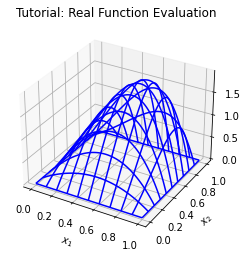

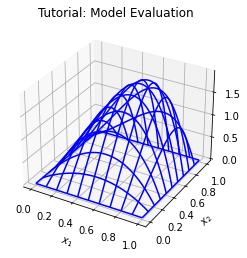

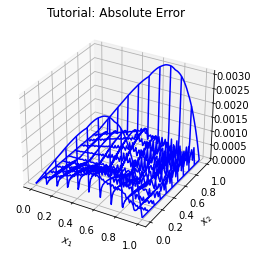

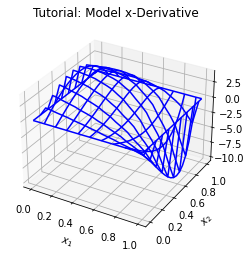

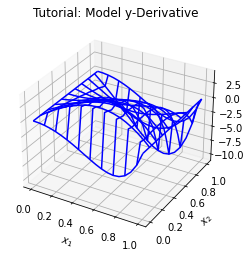

In [44]:
from sparsetorch.plotter import plot_3D
name='Tutorial: Real Function Evaluation'
plot_3D(f_dD, name, steps=100)

name='Tutorial: Model Evaluation'
plot_3D(model, name, steps=100)

name='Tutorial: Absolute Error'
plot_3D(lambda x: torch.abs(f_dD(x)-model(x)), name, steps=100)

name='Tutorial: Model x-Derivative'
plot_3D(lambda _: derivative[0], name, steps=20)
# note that the lambda function is a workaround to plot the derivative
# step number has to match step number used for derivatives

name='Tutorial: Model y-Derivative'
plot_3D(lambda _: derivative[1], name, steps=20)
# note that the lambda function is a workaround to plot the derivative
# step number has to match step number used for derivatives